# Question
Someone asked me if there is an easy way to simulate the ability to
measure the expansion of an extended Chandra source. I suggested just
taking an old fits image and either expanding the whole thing to do a
comparison between the original and expanded versions, or to just shift
the image and then analyze the side that "grew."

The second case is ugly, but easy enough to do by just messing with the
fits header (and I've done that before for a big SNR for which we were
only going to image one limb anyway). What about the first case? Do you
have a suggestion or tool for doing this? One could just mess with the
fits header here too, by changing the pixel scale, but that would then
change the size of the pixels and make comparisons difficult. Maybe
change the scale to "expand" the remnant then resample the image at the
original pixel scale? I'm not sure what the best approach would be, but
please let me know if you have any ideas.

## Grab an example dataset

In [1]:
ciaover -v

# packages in environment at /soft/miniconda/envs/ciao:
#
# Name                    Version                   Build  Channel
ciao                      4.13.0           py38h5ec60c1_0    https://cxc.cfa.harvard.edu/conda/ciao
ciao-contrib              4.13.0                     py_4    https://cxc.cfa.harvard.edu/conda/ciao
ds9                       8.2                           2    https://cxc.cfa.harvard.edu/conda/ciao
sherpa                    4.13.0           py38h5ec60c1_0    https://cxc.cfa.harvard.edu/conda/ciao
zciao                     4.13.3                        0    https://hea-www.harvard.edu/~kjg/ciao

System information:
Linux kjg-XPS-8940 5.8.0-43-generic #49~20.04.1-Ubuntu SMP Fri Feb 5 09:57:56 UTC 2021 x86_64 x86_64 x86_64 GNU/Linux


In [2]:
download_chandra_obsid 214 cntr_img 


  Type     Format      Size  0........H.........1  Download Time Average Rate
  ---------------------------------------------------------------------------
  cntr_img jpg       731 Kb    already downloaded
  cntr_img fits      316 Kb    already downloaded



In [3]:
dmcopy 214/primary/acisf00214N003_cntr_img2.fits.gz img.fits clob+

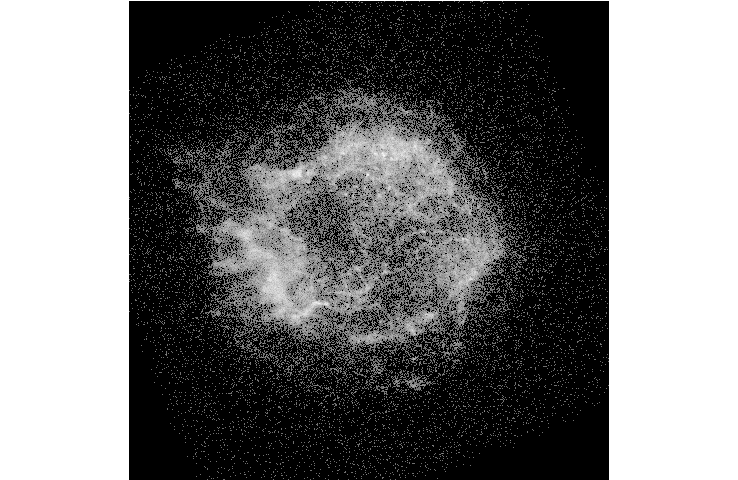

In [4]:
ds9 img.fits -scale log -zoom to fit -view colorbar no -saveimage png img.png -exit
display < img.png

In [5]:
dmlist img.fits cols

 
--------------------------------------------------------------------------------
Columns for Image Block IMAGE
--------------------------------------------------------------------------------
 
ColNo  Name                 Unit        Type             Range
   1   IMAGE[1024,1024]                  Int4(1024x1024) -                    
 
--------------------------------------------------------------------------------
Physical Axis Transforms for Image Block IMAGE
--------------------------------------------------------------------------------
 
Group# Axis# 
   1   1,2    sky(x) = (+3333.120) +(+1.0)* ((#1)-(+0.50))
                 (y)   (+3463.660)  (+1.0)  ((#2) (+0.50))
 
--------------------------------------------------------------------------------
World Coordinate Axis Transforms for Image Block IMAGE
--------------------------------------------------------------------------------
 
Group# Axis# 
   1   1,2    EQPOS(RA ) = (+350.7909)[deg] +TAN[(-0.000136667)* (sky(x)-(+4096.50

In [6]:
xcenter=3809.2791
ycenter=3952.2981
scale=1.2

## making a fake dataset

I'm going to start with a simple fake dataset that I can easily see that things are working before trying on the real thing.


In [7]:
get_sky_limits img.fits

Running: get_sky_limits
  version: 07 October 2016
Checking binning of image: img.fits
  Image has 1024 x 1024 pixels
  Pixel size is 1.0 by 1.0
  Lower left (0.5,0.5) corner is x,y= 3333.1, 3463.7
  Upper right (1024.5,1024.5) corner is x,y= 4357.1, 4487.7
  DM filter is:
    x=3333.1:4357.1:#1024,y=3463.7:4487.7:#1024
  mkexpmap xygrid value is:
    3333.1:4357.1:#1024,3463.7:4487.7:#1024


In [8]:
# Make a simple ASCII file
echo "#x y" > fake.dat
echo $xcenter $ycenter >> fake.dat

In [9]:
# Bin the image to create a delta function at the center pixel location
dmcopy "fake.dat[bin x=3333.1:4357.1:#1024,y=3463.7:4487.7:#1024]" fake_delta.img clob+

In [10]:
# Smooth the image with a big hemisphere
aconvolve fake_delta.img out=fake_sphere.img kernelspec="lib:sphere(2,100)" method=fft clob+ norm=none

In [11]:
# trick to copy WCS from real image to fake image
dmimgcalc img.fits,fake_sphere.img none out=fake.img op="imgout=((img1-img1)+img2)" clob+ lookup=""

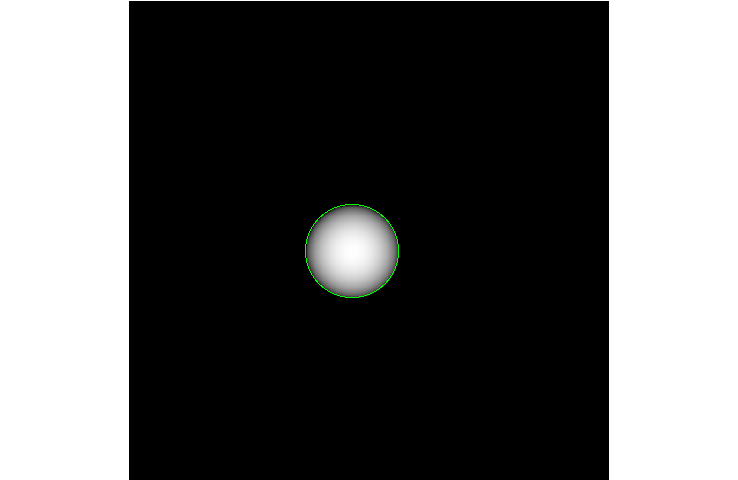

In [12]:
ds9 fake.img -scale linear -zoom to fit -view colorbar no \
  -regions command "physical; circle $xcenter $ycenter 100" \
  -saveimage png fake.png -exit
display < fake.png

## Okay -- now let's do a dry-run on test image

So the idea is to

- Reproject the data so that the center of the expansion is at the tanget point, `reproject_image_grid`
- Tweak the WCS scale factor, `wcs_update`
- Then reproject the image back to the original coordinate system, `reproject_image`


### `reproject_image_grid`

This tool lets you generate an entirely new image with new WCS.  We need to get the tangent point in celestial coordinates (degrees) so we use `dmcoords`


In [13]:
punlearn dmcoords
dmcoords fake.img op=sky x=$xcenter y=$ycenter celfmt=deg verb=0
pget dmcoords ra dec

350.8666893383814
58.81177237298929


In [14]:
reproject_image_grid \
  infile=fake.img \
  outfile=fake_reproject.img \
  xsize=1024 ysize=1024 \
  xcenter=350.8666893383814 \
  ycenter=58.81177237298929 \
  theta=0 \
  pixelsize=0.000136667 \
  projection=tan method=sum coord=world \
  clob+ 

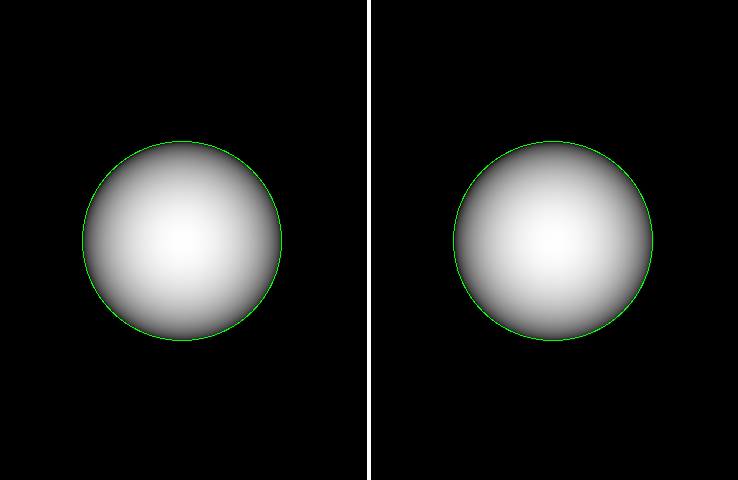

In [15]:
ds9 -scale linear fake.img \
  -regions command "physical; circle $xcenter $ycenter 100" \
  fake_reproject.img \
  -regions command "physical; circle $xcenter $ycenter 100" \
  -match frame wcs \
  -view colorbar no \
  -saveimage png fake_01.png -quit
display < fake_01.png


### `wcs_update`

`wcs_update` modifies the file in place so we make a copy first and then apply our scaling factor


In [16]:
dmcopy fake_reproject.img fake_wcs_scale.img clob+

In [17]:
wcs_update \
  fake_wcs_scale.img \
  outfile= transform=none wcsfile=fake_wcs_scale.img \
  scalefac=$scale

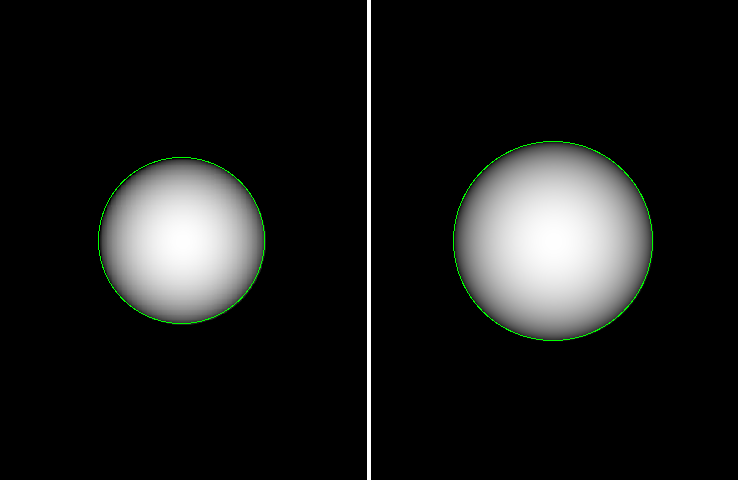

In [18]:
ds9 -scale linear fake.img \
  -regions command "physical; circle $xcenter $ycenter 100" \
  fake_wcs_scale.img \
  -regions command "physical; circle $xcenter $ycenter 100" \
  -match frame wcs \
  -view colorbar no \
  -saveimage png fake_02.png -quit
display < fake_02.png

Okay, we can see the expansion in ds9, but this is just in the display.  The pixel values in the image have not yet been stretched.

### `reproject_image`

Okay, now reproject it back to the original WCS

In [19]:
reproject_image \
  in=fake_wcs_scale.img \
  out=fake_match.img \
  match=fake.img \
  mode=h clob+

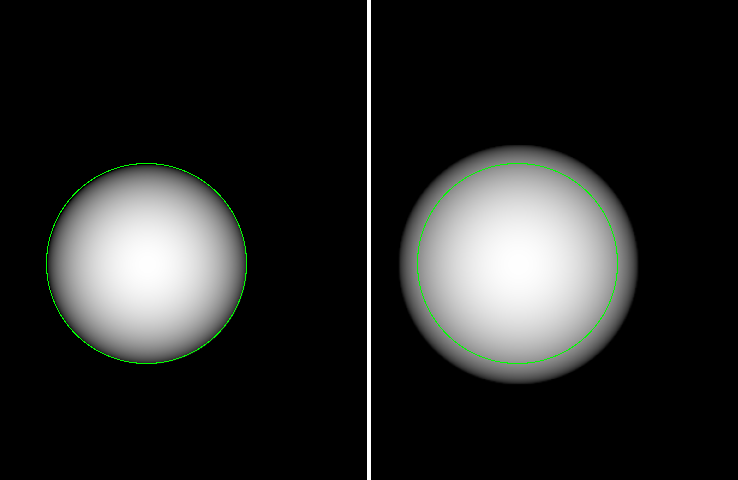

In [20]:
# Note: no match frame on wcs!
ds9 -scale linear fake.img \
  -regions command "physical; circle $xcenter $ycenter 100" \
  fake_match.img \
  -regions command "physical; circle $xcenter $ycenter 100" \
  -view colorbar no \
  -saveimage png fake_03.png -quit
display < fake_03.png

Okay that looks like it's working.

## Try on real data

same steps as before (almost)

In [21]:
reproject_image_grid \
  infile=img.fits \
  outfile=img_reproject.fits \
  xsize=1024 ysize=1024 \
  xcenter=350.8666893383814 \
  ycenter=58.81177237298929 \
  theta=0 \
  pixelsize=0.000136667 \
  projection=tan method=sum coord=world \
  resolution=0 \
  clob+ 

In [22]:
dmcopy img_reproject.fits img_wcs_scale.fits clob+

In [23]:
wcs_update \
  img_wcs_scale.fits \
  outfile= transform=none wcsfile=img_wcs_scale.fits \
  scalefac=$scale

In [24]:
reproject_image \
  in=img_wcs_scale.fits \
  out=img_match.fits \
  match=img.fits \
  resolution=0 \
  mode=h clob+

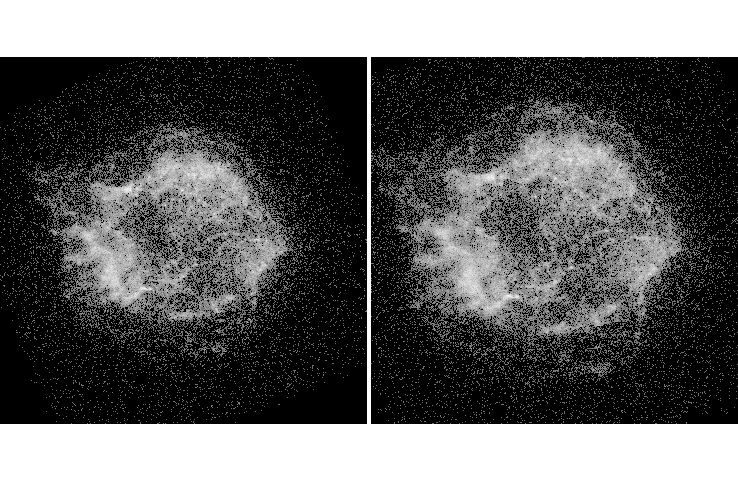

In [25]:
ds9 -scale log img.fits img_match.fits \
  -frame 1 -zoom to fit \
  -frame 2 -zoom to fit \
  -view colorbar no \
  -saveimage png img_01.png -exit

display < img_01.png  

Okay, this looks to have worked.

### `resolution=0`

I said "almost" before.  That's because I set `resolution=0` in both `reproject_image` and `reproject_image_grid` tools.

The way these tools work is to map each pixels boundaries in the input image to the output image and redistributes the counts (pixel value) proportional to the area the input pixel covers in the output image.  So fractional pixels, meaning fractional counts.

With `resolution=0` only the center of the pixel is mapped from input image to output image, and all the counts are assigned to that pixel.  This preserves integer counts (although the output image is written as real, floating point values).  But it can lead to some aliasing effects -- but that's usually more a problem when rotating.




## Future 

Well, since you mentioned "resampling" ...

I've got a prototype for a tool to do as you suggested : resample counts image on one WCS to a new WCS.

https://github.com/kglotfelty/resample_image

This gets around the `resolution=0` issue and avoids the aliasing effects.

However, it is sampling, so it does introduce a randomization into the process.


In [26]:
resample_image \
  in=img_wcs_scale.fits \
  out=img_resample.fits \
  match=img.fits \
  randseed=123456 \
  mode=h clob+  

# resample_image (CIAO 4.13): ERROR: The input image must be an integer datatype.


: 255

In [27]:
resample_image \
  in=img_wcs_scale.fits"[opt type=i4]" \
  out=img_resample.fits \
  match=img.fits \
  randseed=123456 \
  mode=h clob+  

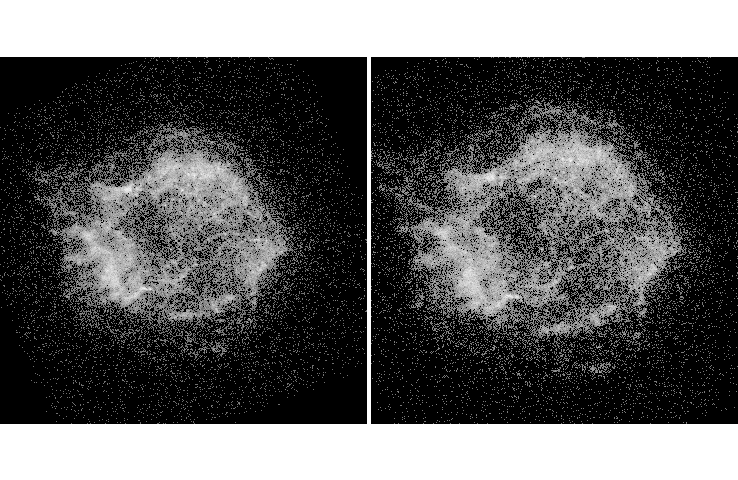

In [28]:
ds9 -scale log img.fits img_resample.fits \
  -frame 1 -zoom to fit \
  -frame 2 -zoom to fit \
  -view colorbar no \
  -saveimage png img_02.png -exit

display < img_02.png  

I'm hoping to get this tool added to CIAO at some point.

If you want to try it, I can send installation instructions. (It's trival with ciao installed using conda. For ciao-install you need to build from source; but you do not need all the ciao source code to do it.)